# Face Anti-Spoofing Detection #

Video-Based detection using dlib (68-landmark)

## Overview of the Approach ##

Input: VIDEO_DURATION=10 seconds from webcam
Process:

1. Capture frames from webcam for 10 seconds.
2. Detect face + 68 landmarks via dlib
3. Compute per-frame signals: EAR (blinks), nose/center motion, optical flow
4. Score the video and decide liveness; if live, save best frame (largest face)

## Install Dependencies ##

In [ ]:
#!pip install opencv-python dlib numpy matplotlib

## Imports ##

In [15]:
import cv2
import dlib
import numpy as np
import time
import os
from math import hypot
import matplotlib.pyplot as plt

## Constraints ##

In [16]:
## Constraints ##
VIDEO_DURATION = 10              # seconds to capture
CAPTURE_FPS = 15                 # target fps
EAR_THRESHOLD = 0.21             # Eye Aspect Ratio threshold for closed eye
EAR_CONSEC_FRAMES = 2            # consecutive frames below EAR to count a blink
MIN_BLINKS = 1                   # minimum blinks to consider liveness
OPTICAL_FLOW_THRESH = 1.0        # avg optical flow magnitude threshold (tune)
HEAD_MOTION_THRESH = 0.01        # normalized motion threshold (fraction of face width)
MIN_FACE_FRAMES = 6              # minimum frames containing a face to evaluate
OUTPUT_FRAME_PATH = "../data/images/temp/best_frame.jpg"
os.makedirs(os.path.dirname(OUTPUT_FRAME_PATH), exist_ok=True)

In [17]:
# Path to dlib's 68-landmark model (download if you don't have it)
SHAPE_PREDICTOR_PATH = "../shape_predictor_68_face_landmarks.dat"
if not os.path.exists(SHAPE_PREDICTOR_PATH):
    raise FileNotFoundError(
        f"Missing dlib shape predictor. Download from:\n"
        "https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2\n"
        "Unzip and place the .dat file at: " + SHAPE_PREDICTOR_PATH
    )


In [18]:
# dlib models
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(SHAPE_PREDICTOR_PATH)

## Utility Functions ##

In [19]:
def euclidean(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

In [20]:
def eye_aspect_ratio(eye_points):
    # eye_points: list of 6 (x,y) coords in order [p1,p2,p3,p4,p5,p6]
    # EAR = (||p2-p6|| + ||p3-p5||) / (2 * ||p1-p4||)
    p1, p2, p3, p4, p5, p6 = eye_points
    A = euclidean(p2, p6)
    B = euclidean(p3, p5)
    C = euclidean(p1, p4)
    if C == 0:
        return 0.0
    ear = (A + B) / (2.0 * C)
    return ear

## dlib 68-point indices (0-based) ##

In [21]:
RIGHT_EYE_IDX = [36, 37, 38, 39, 40, 41]   # right eye (x6)
LEFT_EYE_IDX  = [42, 43, 44, 45, 46, 47]   # left eye (x6)
NOSE_TIP_IDX = 30                          # nose tip index in dlib 68
RIGHT_OUTER = 36                           # right outer eye corner (for face width)
LEFT_OUTER = 45                            # left outer eye corner

## Capture 10-second video into frames (in memory) ##

In [22]:
def capture_video_frames(duration=VIDEO_DURATION, target_fps=CAPTURE_FPS):
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise RuntimeError("Could not open webcam (device 0).")

    # Try to set fps (may not be effective on all webcams)
    cap.set(cv2.CAP_PROP_FPS, target_fps)
    frames = []
    start = time.time()
    print("Recording... (press Ctrl+C to stop early)")
    try:
        while time.time() - start < duration:
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame.copy())
            # small wait to control effective fps
            cv2.waitKey(int(1000 / target_fps))
    finally:
        cap.release()
    print(f"Captured {len(frames)} frames.")
    return frames


## Analyze frames: landmarks, EAR, head motion, optical flow ##

In [23]:
def analyze_frames_for_liveness(frames):
    if len(frames) < 2:
        return {"status": -1, "reason": "not_enough_frames"}

    ear_list = []          # per-frame average EAR
    blink_count = 0
    ear_below = 0
    nose_positions = []    # (x,y) per frame in pixels
    face_bbox_areas = []   # area of face bbox per frame
    gray_prev = None
    flow_mags = []

    face_frames_idx = []   # indices where a face was found
    face_widths = []

    for idx, frame in enumerate(frames):
        h, w = frame.shape[:2]
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # detect faces
        dets = detector(gray, 0)
        if len(dets) == 0:
            ear_list.append(None)
            nose_positions.append(None)
            face_bbox_areas.append(0)
            continue

        # take the first face
        face_frames_idx.append(idx)
        d = dets[0]
        shape = predictor(gray, d)
        coords = np.array([[pt.x, pt.y] for pt in shape.parts()])

        # helper to get pixel coords for an index
        def lm(i):
            return (int(coords[i][0]), int(coords[i][1]))

        # compute EAR for both eyes if possible
        try:
            right_eye_pts = [lm(i) for i in RIGHT_EYE_IDX]
            left_eye_pts  = [lm(i) for i in LEFT_EYE_IDX]
            ear_r = eye_aspect_ratio(right_eye_pts)
            ear_l = eye_aspect_ratio(left_eye_pts)
            ear = (ear_r + ear_l) / 2.0
        except Exception:
            ear = None
        ear_list.append(ear)

        # nose tip
        try:
            nose = lm(NOSE_TIP_IDX)
            nose_positions.append(nose)
        except Exception:
            nose_positions.append(None)

        # approximate face bbox area using coords
        try:
            xs = coords[:, 0]
            ys = coords[:, 1]
            x_min, x_max = int(xs.min()), int(xs.max())
            y_min, y_max = int(ys.min()), int(ys.max())
            face_width = max(1, x_max - x_min)
            face_height = max(1, y_max - y_min)
            area = face_width * face_height
        except Exception:
            area = 0
            face_width = 1
        face_bbox_areas.append(area)
        face_widths.append(face_width)

        # optical flow between current and previous grayscale
        if gray_prev is not None:
            flow = cv2.calcOpticalFlowFarneback(gray_prev, gray,
                                                None, 0.5, 3, 15, 3, 5, 1.2, 0)
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            mean_mag = float(np.mean(mag))
            flow_mags.append(mean_mag)
        gray_prev = gray

    # analyze EAR series for blinks
    for e in ear_list:
        if e is None:
            ear_below = 0
            continue
        if e < EAR_THRESHOLD:
            ear_below += 1
        else:
            if ear_below >= EAR_CONSEC_FRAMES:
                blink_count += 1
            ear_below = 0
    # final check
    if ear_below >= EAR_CONSEC_FRAMES:
        blink_count += 1

    # compute head motion by nose displacement normalized by mean face width
    valid_noses = [p for p in nose_positions if p is not None]
    if len(valid_noses) >= 2:
        nose_disps = []
        for i in range(1, len(nose_positions)):
            if nose_positions[i] is None or nose_positions[i - 1] is None:
                continue
            d = euclidean(nose_positions[i], nose_positions[i - 1])
            nose_disps.append(d)
        mean_face_width = np.mean(face_widths) if face_widths else 1.0
        if mean_face_width <= 0:
            normalized_nose_disp = 0.0
        else:
            normalized_nose_disp = float(np.mean(nose_disps) / (mean_face_width + 1e-6)) if nose_disps else 0.0
    else:
        normalized_nose_disp = 0.0

    avg_flow = float(np.mean(flow_mags)) if flow_mags else 0.0
    face_frames_count = len(face_frames_idx)

    metrics = {
        "blink_count": blink_count,
        "avg_ear": None if not ear_list else (np.nanmean([e for e in ear_list if e is not None]) if any(e is not None for e in ear_list) else None),
        "avg_flow": avg_flow,
        "normalized_nose_motion": normalized_nose_disp,
        "face_frames_count": face_frames_count,
        "face_bbox_areas": face_bbox_areas,
        "ear_series": ear_list,
        "flow_series": flow_mags,
    }
    return metrics

## Decision logic (combine signals) ##

In [24]:
def decide_liveness(metrics,
                    min_blinks=MIN_BLINKS,
                    flow_thresh=OPTICAL_FLOW_THRESH,
                    head_motion_thresh=HEAD_MOTION_THRESH,
                    min_face_frames=MIN_FACE_FRAMES):
    # Quick checks
    if metrics["face_frames_count"] < min_face_frames:
        return -1, "not_enough_face_frames"

    # Booleans
    blink_ok = metrics["blink_count"] >= min_blinks
    flow_ok = metrics["avg_flow"] >= flow_thresh
    head_motion_ok = metrics["normalized_nose_motion"] >= head_motion_thresh

    # Weighted scoring (tunable)
    score = 0.0
    score += 0.6 * (1.0 if blink_ok else 0.0)    # blinks = strong evidence
    score += 0.2 * (1.0 if flow_ok else 0.0)
    score += 0.2 * (1.0 if head_motion_ok else 0.0)

    # threshold for pass
    PASS_SCORE = 0.4   # require at least some evidence; blink alone (0.6) would pass
    passed = score >= PASS_SCORE

    debug = {
        "blink_ok": blink_ok,
        "flow_ok": flow_ok,
        "head_motion_ok": head_motion_ok,
        "score": score,
        "blink_count": metrics["blink_count"],
        "avg_flow": metrics["avg_flow"],
        "normalized_nose_motion": metrics["normalized_nose_motion"],
        "face_frames_count": metrics["face_frames_count"]
    }
    if passed:
        return True, debug
    else:
        return False, debug

## Pick best frame (largest face) and save ##

In [25]:
def pick_best_frame_and_save(frames, metrics, out_path=OUTPUT_FRAME_PATH):
    areas = metrics["face_bbox_areas"]
    if not areas:
        return None
    best_idx = int(np.argmax(areas))
    best_frame = frames[best_idx]
    cv2.imwrite(out_path, best_frame)
    return out_path

## Full end-to-end pipeline usage ##

In [26]:
def anti_spoofing_video_pipeline(duration=VIDEO_DURATION):
    frames = capture_video_frames(duration=duration)
    metrics = analyze_frames_for_liveness(frames)
    decision, debug = decide_liveness(metrics)
    if decision is True:
        best = pick_best_frame_and_save(frames, metrics)
        print("✅ Live detected. Best frame saved to:", best)
        print("Debug:", debug)
        return True, best, metrics, debug
    elif decision is False:
        print("🛑 Spoof detected. Debug:", debug)
        return False, None, metrics, debug
    else:
        print("⚠️ Not enough face frames or error. Reason:", debug if isinstance(debug, str) else debug)
        return -1, None, metrics, debug

Recording... (press Ctrl+C to stop early)
Captured 124 frames.
✅ Live detected. Best frame saved to: ../data/images/temp/best_frame.jpg
Debug: {'blink_ok': True, 'flow_ok': False, 'head_motion_ok': False, 'score': 0.6, 'blink_count': 10, 'avg_flow': 0.052890167942589356, 'normalized_nose_motion': 0.0072187501345905925, 'face_frames_count': 124}


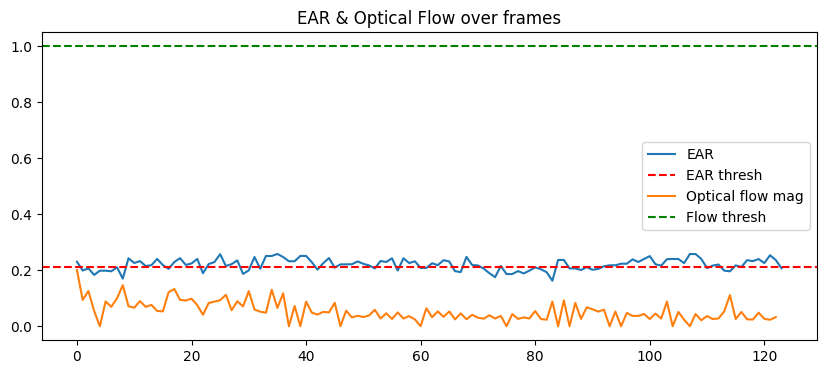

In [28]:
if __name__ == "__main__":
    status, frame_path, metrics, debug = anti_spoofing_video_pipeline()
    # Visualize metrics & debug (optional)
    def visualize_metrics(metrics):
        plt.figure(figsize=(10,4))
        if metrics["ear_series"]:
            ears = [e if e is not None else np.nan for e in metrics["ear_series"]]
            plt.plot(ears, label="EAR")
            plt.axhline(EAR_THRESHOLD, color='r', linestyle='--', label='EAR thresh')
        if metrics["flow_series"]:
            plt.plot(metrics["flow_series"], label="Optical flow mag")
            plt.axhline(OPTICAL_FLOW_THRESH, color='g', linestyle='--', label='Flow thresh')
        plt.legend()
        plt.title("EAR & Optical Flow over frames")
        plt.show()

    visualize_metrics(metrics)

## Visualize metrics & debug (optional) ##

In [11]:
def visualize_metrics(metrics):
    plt.figure(figsize=(10,4))
    if metrics["ear_series"]:
        ears = [e if e is not None else np.nan for e in metrics["ear_series"]]
        plt.plot(ears, label="EAR")
        plt.axhline(EAR_THRESHOLD, color='r', linestyle='--', label='EAR thresh')
    if metrics["flow_series"]:
        plt.plot(metrics["flow_series"], label="Optical flow mag")
        plt.axhline(OPTICAL_FLOW_THRESH, color='g', linestyle='--', label='Flow thresh')
    plt.legend()
    plt.title("EAR & Optical Flow over frames")
    plt.show()

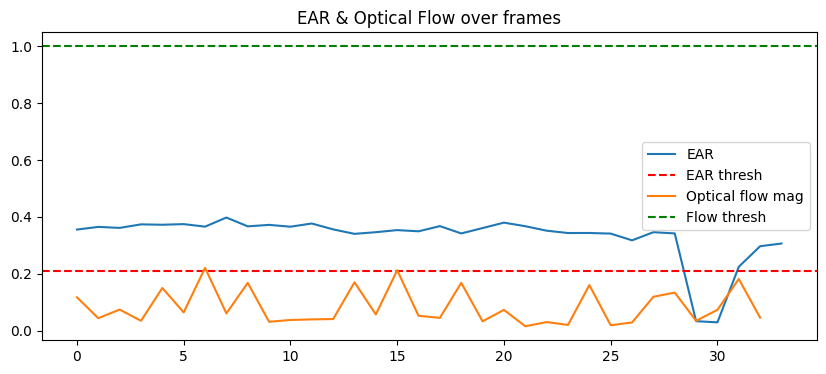

In [27]:
visualize_metrics(metrics)